In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import sklearn.preprocessing
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [3]:
# Saving the original copy
orig= df.copy()

In [4]:
df.dtypes

Datetime     object
DOM_MW      float64
dtype: object

In [5]:
df.shape

(116189, 2)

In [6]:
 df = df[df['Datetime'].str.contains("00:00:00")]
df

,Datetime,DOM_MW
23,2006-01-01 00:00:00,9649.0
47,2005-12-31 00:00:00,9945.0
71,2005-12-30 00:00:00,9521.0
95,2005-12-29 00:00:00,9045.0
119,2005-12-28 00:00:00,10493.0
...,...,...
116092,2018-01-06 00:00:00,18620.0
116116,2018-01-05 00:00:00,17719.0
116140,2018-01-04 00:00:00,14660.0
116164,2018-01-03 00:00:00,17499.0


In [7]:
# Creating a datetime field that is used as datetime rather than
df['Datetime'] = pd.to_datetime(df.Datetime ,format = '%Y-%m-%d %H:%M:%S')
df.index = df.Datetime
df.drop(['Datetime'], axis = 1,inplace = True)
df

,DOM_MW
Datetime,
2006-01-01,9649.0
2005-12-31,9945.0
2005-12-30,9521.0
2005-12-29,9045.0
2005-12-28,10493.0
...,...
2018-01-06,18620.0
2018-01-05,17719.0
2018-01-04,14660.0


In [8]:
df.dtypes

DOM_MW    float64
dtype: object

In [9]:
df.shape

(4841, 1)

In [10]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

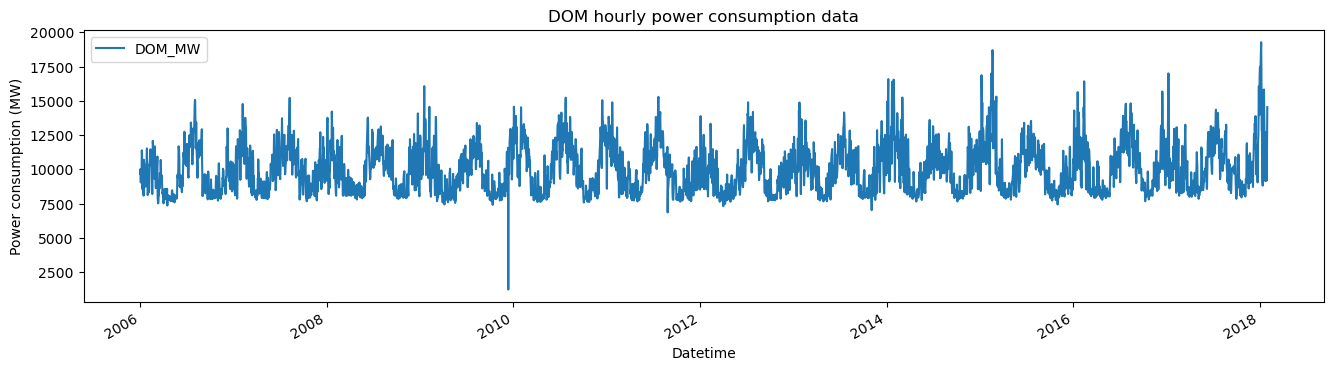

In [11]:
#@title Date Range
a = '2005-12-31'#@param {type:"date"}
b = '2018-01-31' #@param {type:"date"}

a = a+" 00:00:00"
b = b+" 00:00:00"
df.loc[a:b].plot(figsize = (16,4),legend = True)

plt.title('DOM hourly power consumption data')
plt.ylabel('Power consumption (MW)')
plt.show()

In [12]:
#Scaliing the data
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))

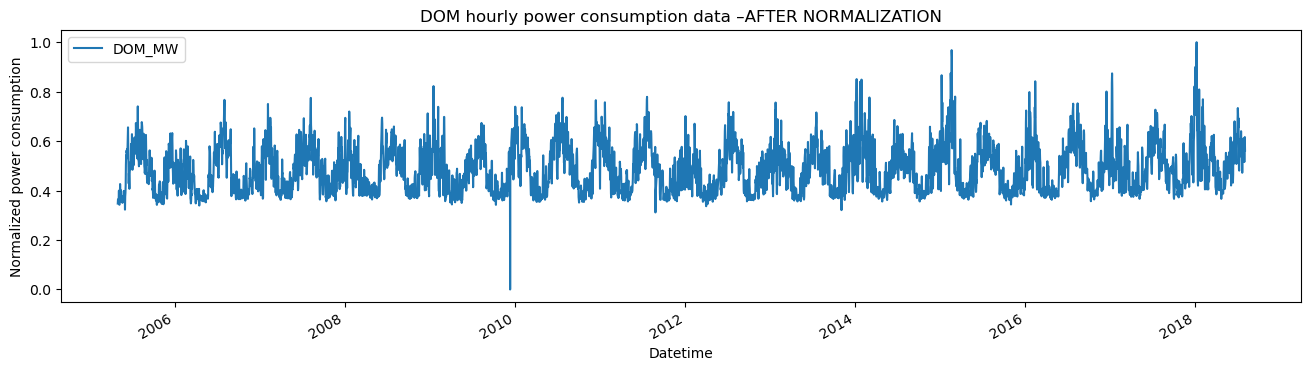

In [13]:
df.plot(figsize = (16,4), legend = True)
plt.title('DOM hourly power consumption data –AFTER NORMALIZATION')
plt.ylabel('Normalized power consumption')
plt.show()

In [14]:
## Creating Training/Testing Datasets
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    X_test = X_train[int(0.9*(len(stock))):]
    y_test = y_train[int(0.9*(len(stock))):]
    X_train = X_train[:int(0.9*(len(stock)))]
    y_train = y_train[:int(0.9*(len(stock)))]
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # reshape data to input into RNN models
    X_train = np.reshape(X_train,
    (X_train.shape[0], seq_len, 1))
    X_test = np.reshape(X_test,
    (X_test.shape[0], seq_len, 1))
    return [X_train, y_train, X_test, y_test]

In [15]:
#create train, test data
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [16]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4356, 20, 1)
y_train.shape =  (4356,)
X_test.shape =  (465, 20, 1)
y_test.shape =  (465,)


In [17]:
#Creating Input Tensor
batch_size = 256
buffer_size = 1000
train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()

In [18]:
# Building Model
rnn_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape =X_train.shape[-2:]),
                                        tf.keras.layers.Dense(1)
                                       ])

C:\Users\Brian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
tf.keras.utils.plot_model(rnn_model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
# Compiling and Training
rnn_model.compile(optimizer = 'adam', loss = 'mae')
EVALUATION_INTERVAL = 200
EPOCHS = 50
rnn_model.fit(train_data, epochs = EPOCHS,steps_per_epoch = EVALUATION_INTERVAL,
              validation_data = test_data,validation_steps = 50
             )

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0484 - val_loss: 0.0547
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0453 - val_loss: 0.0530
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0442 - val_loss: 0.0520
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0434 - val_loss: 0.0511
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0426 - val_loss: 0.0500
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0419 - val_loss: 0.0491
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0410 - val_loss: 0.0485
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0403 - val_loss: 0.0480
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0396 - val_loss: 0.0473
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0388 - val_loss: 0.0478
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0386 - val_loss: 0.0468
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

In [21]:
# Evaluation
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model ="+"{:.4f}".format(rnn_score))
rnn_predictions=rnn_predictions.flatten() # converting the 2d array intoa 1d array
rnn_predictions.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R2 Score of RNN model =0.6817


(465,)

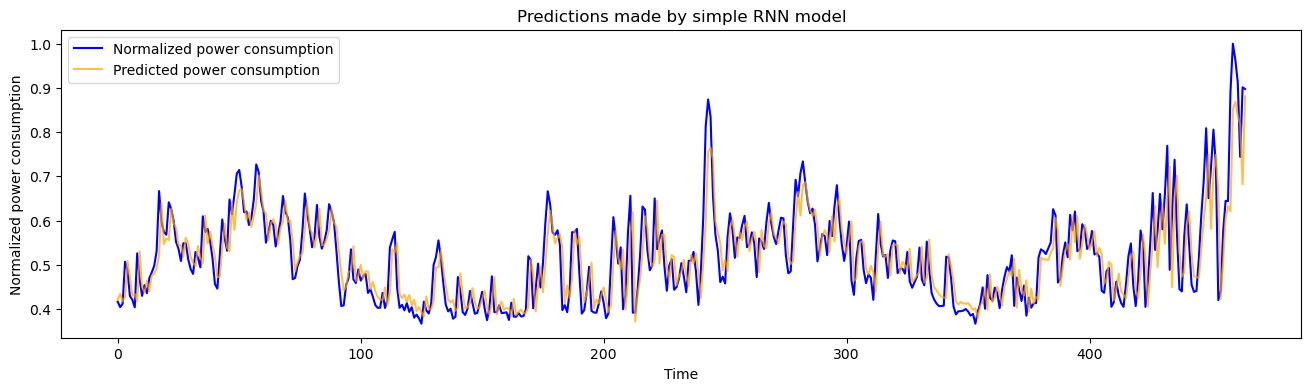

In [22]:
# %matplotlib qt
# Ploting the actual values vs the predicted values
#@title Data Range
a = 0 #@param {type:"slider", min:0,max:12000, step:1}
b = 1200 #@param {type:"slider", min:0,max:12000, step:1}
def plot_predictions(test, predicted, title):
    plt.figure(figsize = (16,4))
    plt.plot(test[a:b], color = 'blue',label ='Normalized power consumption')
    plt.plot(predicted[a:b], alpha = 0.7,
    color = 'orange',
    label = 'Predicted power consumption')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions,"Predictions made by simple RNN model")

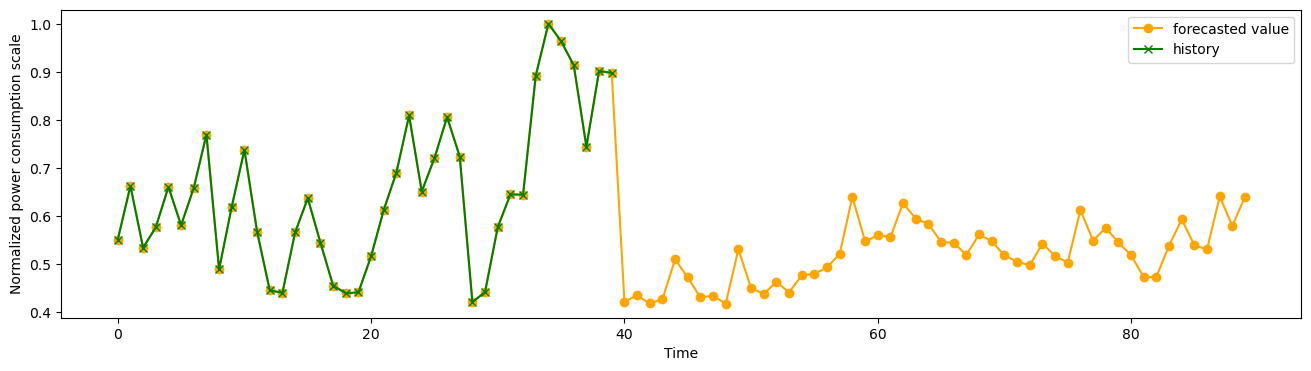

In [23]:
history_data = list(y_test[-40:])
plottingvalues = list(history_data)+list(rnn_predictions[:50])
plt.figure(figsize = (16,4))
plt.plot(plottingvalues, color = 'orange',label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',label = 'history',marker = 'x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()
# print(history_data)


In [55]:
# Predicting Next Data Point
X = X_test[-1:]
print(X.shape)
rnn_predictions1 = rnn_model.predict(X)
type(rnn_predictions1)
len(X)

(1, 20, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1

In [25]:
rnn_predictions1

array([[0.8806447]], dtype=float32)

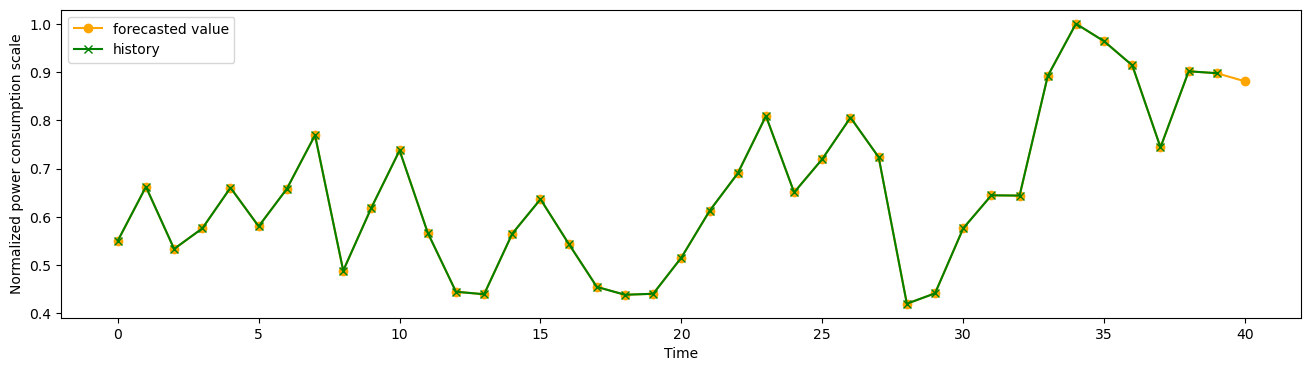

In [26]:
# plot for the last 40 data points along with the predicted value.
history_data = list(y_test[-40:])
plottingvalues = list(history_data)+list(rnn_predictions1.flatten())
plt.figure(figsize = (16,4))
plt.plot(plottingvalues, color = 'orange',label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',label = 'history',marker = 'x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()


In [27]:
# Predicting Range of Data Points
history_data = list(y_test[-40:])
print(history_data)

[0.5503828653867495, 0.6622461436022639, 0.5335700810120964, 0.576073687715015, 0.6603595605371213, 0.5802907557429807, 0.6581400510487182, 0.7691710132060814, 0.48851403839751417, 0.6189657085784042, 0.7375430029963378, 0.5669182110753523, 0.4449006769503939, 0.4396293419154367, 0.5653090666962601, 0.6365553212739984, 0.5442792142936411, 0.45483298191099764, 0.43857507490844516, 0.4406836089224281, 0.5157030296304517, 0.612362667850405, 0.6901564754189324, 0.8089002330484962, 0.6505937187881478, 0.7198424148263234, 0.8056819442903118, 0.7234491177449783, 0.4200421706802797, 0.4415714127177893, 0.5762401509266452, 0.6446010431694595, 0.6439906780601486, 0.8917989124403507, 1.0, 0.9636555321273998, 0.9136610809011209, 0.7439240927754965, 0.901453778714904, 0.8975141493729886]


In [56]:
def make_data(X,rnn_predictions1):
    val = X[0][1:]+list(rnn_predictions1)
    X_new = []
    X_new.append(list(val))
    X_new = np.array(X_new)
    return X_new

In [57]:
forecast = list()
X = X_test[-1:]
print(X.shape)
# X[0][1:].flatten()
len(list(X[0][1:]))

(1, 20, 1)


19

In [58]:
# Defining a loop to create the test data
for i in range (15):
    X = make_data(X,rnn_predictions1)
    rnn_predictions1 = rnn_model.predict(X)
    forecast += rnn_predictions1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [59]:
X = make_data(X,rnn_predictions1)
X

array([[[37.60649782],
        [37.55650337],
        [37.38676639],
        [37.54429607]]])

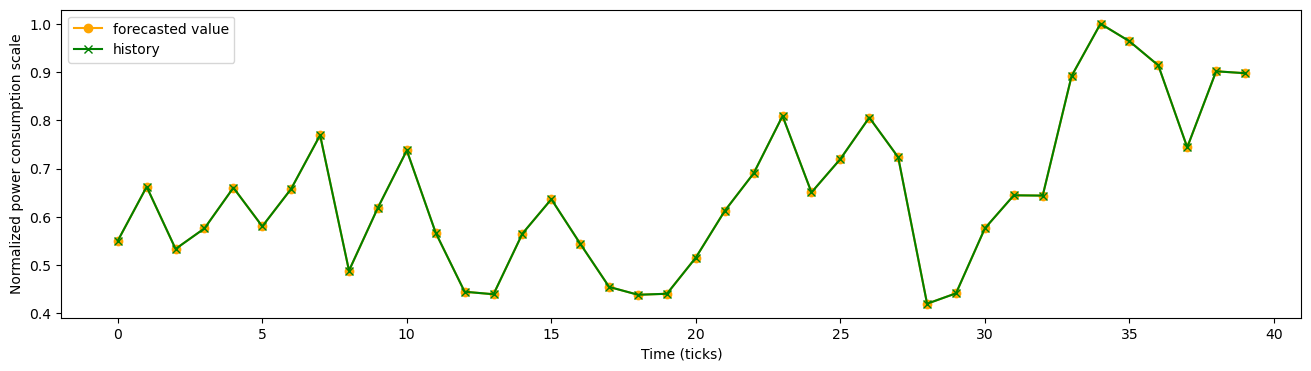

In [46]:
plottingvalues = list(history_data)+list(forecast.flatten())
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color = 'orange',label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',label = 'history',marker = 'x')
plt.xlabel('Time (ticks)')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()